<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/signal-demonstration/colabs/signal_interest_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIGNAL**ing Interest Data

**Description:** Generating `interest` dataframe via SIGNAL API.

**Copyright 2022 SRI International.**

This project is under the GPL3 License. See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

## &#9776; Preamble

Install the `SIGNAL API` client

In [ ]:
!curl https://signal.cta.sri.com/client > client.tgz
!tar xzf client.tgz
!pip install -r signal_api_client/requirements.txt
!pip install -e signal_api_client
!pip install ipympl
%cd /content/signal_api_client   

Download the `funcs` utilities repository.

In [1]:
!git clone https://github.com/hsanchez/funcs.git &> /dev/null

## &#9776; Dependencies

In [2]:
import os
import sys
import time
import warnings

import json
import pickle
import pathlib
import zipfile
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Any, Dict, Tuple
from datetime import date, datetime

In [3]:
os.chdir(f'./funcs')
!git fetch

In [4]:
!git checkout activity_roles_detection_colab &> /dev/null

In [5]:
import funcs as utils

In [6]:
import spacy

In [7]:
from signal_api import signal

## &#9997; Configuration

In [8]:
warnings.filterwarnings("ignore")

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
np.random.seed(0)

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
from IPython import get_ipython
utils.common.set_default_vars(os.environ, ipython_val=get_ipython())

In [13]:
utils.console.stdout.print(utils.common.is_run_in_colab())

True

## &#9881; Functions

In [14]:
# B.H. note: Add functions that are not already in funcs here...

In [15]:
def get_record_count(table_name: str) -> int:
    query = f"SELECT COUNT(*) FROM {table_name};"
    df_result = signal.query_dataframe(query)
    result = df_result['count'].iloc[0]
    return result

### &#9759; Bot Analysis Functions

In [16]:
REGEX_GREG_ADDED = re.compile('patch \".*\" added to .*')

BOTS = {'tip-bot2@linutronix.de', 'tipbot@zytor.com', 'tip-bot2@tip-bot2',
        'lkp@ff58d72860ac', 'lkp@shao2-debian', 'lkp@xsang-OptiPlex-9020',
        'rong.a.chen@shao2-debian', 'lkp@b50bd4e4e446', 'rong.a.chen@shao2-debian',
        'noreply@ciplatform.org', 'patchwork@emeril.freedesktop.org',
        'pr-tracker-bot@kernel.org'}
        
POTENTIAL_BOTS = {'broonie@kernel.org', 'lkp@intel.com',
                  'boqun.feng@debian-boqun.qqnc3lrjykvubdpftowmye0fmh.lx.internal.cloudapp.net'}

In [17]:
def is_bot(patch: dict) -> bool:
    email_address = patch['email']
    if email_address in BOTS:
        return True
    
    subject_line = patch.get('subject', '')
    if email_address in POTENTIAL_BOTS:
        # Mark Brown's bot and lkp
        if subject_line.startswith('applied'):
            return True
    sender_name = patch.get('senderName', None)
    sender_name = patch.get('name', '') if sender_name is None else sender_name
    if 'tip-bot2' in sender_name or 'syzbot' in sender_name:
        return True
    if 'tip-bot' in sender_name:
        return True
    if sender_name in POTENTIAL_BOTS:
        return True
    if 'kernel test robot' in sender_name:
        return True
    
    if REGEX_GREG_ADDED.match(subject_line):
        return True
    
    # AKPM's bot. AKPM uses s-nail for automated mails, and sylpheed for all
    # other mails. That's how we can easily separate automated mails from
    # real mails. Further, akpm acts as bot if the subject contains [merged]
    if email_address == 'akpm@linux-foundation.org':
        if '[merged]' in subject_line:
            return True

    # syzbot - email format: syzbot-hash@syzkaller.appspotmail.com
    if 'syzbot' in email_address and 'syzkaller.appspotmail.com' in email_address:
        return True
    
    # Github Bot
    if 'noreply@github.com' in email_address:
        return True
    
    # Buildroot's daily results bot
    if '[autobuild.buildroot.net] daily results' in subject_line or \
        'oe-core cve metrics' in subject_line:
            return True
    
    return False

### &#9759; NLP

In [18]:
def fkre_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Reading Ease (FKRE) score"""

    return round(206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllables/total_words), 2)

In [19]:
def fkgl_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Grade Level (FKGL) score"""

    return round(0.39 * (total_words/total_sentences) + 11.8 * (total_syllables/total_words) - 15.59, 2)

In [22]:
def count_syllables(word: str) -> int:
    """source: https://codereview.stackexchange.com/questions/224177/python-function-to-count-syllables-in-a-word"""
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )

In [23]:
def message_length(email_body: str) -> int:
    return len(email_body.split("\n"))

In [24]:
def text_to_spacy_nlp(email_body: str):
    """spacy nlp transformation"""
    return nlp(email_body)

In [25]:
def sentence_count(spacy_txt):
    """calculate the number of sentences in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(list(spacy_txt.sents))

In [26]:
def retrieve_words(spacy_txt):
    return [token.text for token in spacy_txt if not token.is_punct]

In [27]:
def word_count(spacy_txt):
    """calculate the number of words in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(retrieve_words(spacy_txt))

## &#128272; Login

In [28]:
signal.login()

username?: ··········
password?: ··········


True

## &#128722; Data

### &#9759; Tables

In [29]:
TABLES_QUERY = "SELECT * FROM information_schema.tables WHERE table_type='BASE TABLE';"

In [30]:
df_tables = signal.query_dataframe(TABLES_QUERY)

In [31]:
table_names = df_tables.table_name.unique()

In [32]:
print(f"There are {len(table_names)} tables currently present in the SIGNAL database.")

There are 87 tables currently present in the SIGNAL database.


In [33]:
df_tables.head()

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,signal,public,scraped_projects,BASE TABLE,None,None,None,None,None,YES,NO,None
1,signal,public,scraped_patch_series,BASE TABLE,None,None,None,None,None,YES,NO,None
2,signal,public,diff,BASE TABLE,None,None,None,None,None,YES,NO,None
3,signal,public,thread,BASE TABLE,None,None,None,None,None,YES,NO,None
4,signal,public,git_files,BASE TABLE,None,None,None,None,None,YES,NO,None


In [34]:
table_names

array(['scraped_projects', 'scraped_patch_series', 'diff', 'thread',
       'git_files', 'email', 'git_commit_edges', 'pg_statistic',
       'pg_type', 'git_file_changes', 'scraped_patches',
       'alembic_version', 'api_key', 'pg_foreign_table', 'pg_authid',
       'signal_history', 'pg_statistic_ext_data', 'git_repos',
       'user_identities', 'person', 'scraped_patch_submitters',
       'mailing_list', 'git_sigs', 'pg_user_mapping', 'pg_subscription',
       'pg_attribute', 'pg_proc', 'pg_class', 'pg_attrdef',
       'pg_constraint', 'pg_inherits', 'pg_index', 'pg_operator',
       'pg_opfamily', 'pg_opclass', 'pg_am', 'pg_amop', 'pg_amproc',
       'pg_language', 'pg_largeobject_metadata', 'pg_aggregate',
       'pg_statistic_ext', 'pg_rewrite', 'pg_trigger', 'pg_event_trigger',
       'pg_description', 'pg_cast', 'pg_enum', 'pg_namespace',
       'pg_conversion', 'pg_depend', 'pg_database', 'pg_db_role_setting',
       'pg_tablespace', 'pg_auth_members', 'pg_shdepend',
       'p

### &#9759; Email Data

In [45]:
START_DATE = datetime(2020, 8, 1)
END_DATE = datetime(2020, 8, 2)

In [46]:
df_email = signal.query_dataframe(f"SELECT * FROM email WHERE timestamp_sent > {START_DATE.timestamp()} and timestamp_sent < {END_DATE.timestamp()};")

In [47]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   370 non-null    int64 
 1   url                  370 non-null    object
 2   mailing_list_id      370 non-null    int64 
 3   email_id             370 non-null    object
 4   message_id           370 non-null    object
 5   reply_to_url         193 non-null    object
 6   author_id            370 non-null    int64 
 7   timestamp_sent       370 non-null    int64 
 8   timestamp_recv       370 non-null    int64 
 9   subject              370 non-null    object
 10  body                 370 non-null    object
 11  clean_body           370 non-null    object
 12  thread_id            370 non-null    object
 13  persuasion           370 non-null    object
 14  reply_to_message_id  370 non-null    object
dtypes: int64(5), object(10)
memory usage: 43.5+ KB


In [48]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,body,clean_body,thread_id,persuasion,reply_to_message_id
0,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,1596275391,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,This test checks the correctness of BPF_PROG_T...,This test checks the correctness of BPF_PROG_T...,20200801084721.1812607-1-songliubraving@fb.com,Unknown,20200801084721.1812607-1-songliubraving@fb.com
1,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,1596297751,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,"Commit d26e94149276 (""kbuild: no gcc-plugins d...","Commit d26e94149276 (""kbuild: no gcc-plugins d...",20200801150050.767038-1-masahiroy@kernel.org,Unknown,20200801150050.767038-1-masahiroy@kernel.org
2,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,1596290789,[PATCH v11 2/5] x86: kdump: move reserve_crash...,In preparation for supporting reserve_crashker...,In preparation for supporting reserve_crashker...,20200801130856.86625-1-chenzhou10@huawei.com,Unknown,20200801130856.86625-1-chenzhou10@huawei.com
3,33521,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008011049310,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,None,858,1596293371,1596296971,[PATCH] mm/swap.c: optimizing __pagevec_lru_ad...,The current relock logical will change lru_loc...,The current relock logical will change lru_loc...,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,Unknown,
4,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,1596304949,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),"On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...","On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...",e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...


In [49]:
df_email['sent_time'] = pd.to_datetime(df_email['timestamp_sent'] * 10**9) 

# @Huascar, please double-check the method below
# df_email = utils.data.datetime_column_to_timestamp(input_df=df_email, column='timestamp_sent')

In [50]:
df_email['timestamp_recv'] = pd.to_datetime(df_email['timestamp_recv'] * 10**9)

In [51]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,body,clean_body,thread_id,persuasion,reply_to_message_id,sent_time
0,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,2020-08-01 09:49:51,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,This test checks the correctness of BPF_PROG_T...,This test checks the correctness of BPF_PROG_T...,20200801084721.1812607-1-songliubraving@fb.com,Unknown,20200801084721.1812607-1-songliubraving@fb.com,2020-08-01 08:49:51
1,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,2020-08-01 16:02:31,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,"Commit d26e94149276 (""kbuild: no gcc-plugins d...","Commit d26e94149276 (""kbuild: no gcc-plugins d...",20200801150050.767038-1-masahiroy@kernel.org,Unknown,20200801150050.767038-1-masahiroy@kernel.org,2020-08-01 15:02:31
2,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,2020-08-01 14:06:29,[PATCH v11 2/5] x86: kdump: move reserve_crash...,In preparation for supporting reserve_crashker...,In preparation for supporting reserve_crashker...,20200801130856.86625-1-chenzhou10@huawei.com,Unknown,20200801130856.86625-1-chenzhou10@huawei.com,2020-08-01 13:06:29
3,33521,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008011049310,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,None,858,1596293371,2020-08-01 15:49:31,[PATCH] mm/swap.c: optimizing __pagevec_lru_ad...,The current relock logical will change lru_loc...,The current relock logical will change lru_loc...,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,Unknown,,2020-08-01 14:49:31
4,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,2020-08-01 18:02:29,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),"On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...","On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...",e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,2020-08-01 17:02:29


In [52]:
total_email_records = get_record_count(table_name='email')
print(f"In total, there are {total_email_records:,} email records in the database.")

In total, there are 421,403 email records in the database.


### &#9759; Patches Data

In [53]:
total_patch_records = get_record_count(table_name='scraped_patches')
print(f"In total, there are {total_patch_records:,} patch records in the database.")

In total, there are 938,137 patch records in the database.


In [54]:
df_patches = signal.query_dataframe(f"SELECT * FROM scraped_patches;")

In [55]:
df_patches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938137 entries, 0 to 938136
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             938137 non-null  int64  
 1   project_id     938137 non-null  int64  
 2   patch_id       938137 non-null  int64  
 3   mail_id        938137 non-null  object 
 4   name           938137 non-null  object 
 5   series_id      935162 non-null  float64
 6   ack_count      938137 non-null  int64  
 7   review_count   938137 non-null  int64  
 8   tested_count   938137 non-null  int64  
 9   success_count  938137 non-null  int64  
 10  warning_count  938137 non-null  int64  
 11  fail_count     938137 non-null  int64  
 12  date           938137 non-null  object 
 13  submitter_id   938137 non-null  int64  
 14  delegate       125878 non-null  object 
 15  state          938137 non-null  object 
 16  commit_hash    0 non-null       object 
dtypes: float64(1), int64(10), obj

In [56]:
df_patches.head()

,id,project_id,patch_id,mail_id,name,series_id,ack_count,review_count,tested_count,success_count,warning_count,fail_count,date,submitter_id,delegate,state,commit_hash
0,1,1,11614315,20200619142922.GA267142@mwanda,[net-next] ath11k: fix uninitialized return in...,1.0,0,0,0,0,0,0,2020-06-19T00:00:00,1,None,New,None
1,2,1,11611413,1592458104-2961-4-git-send-email-akolli@codeau...,"[v3,3/3] ath11k: add IPQ6018 support",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
2,3,1,11611417,1592458104-2961-3-git-send-email-akolli@codeau...,"[v3,2/3] ath11k: copy ce service configs to hw...",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
3,4,1,11611415,1592458104-2961-2-git-send-email-akolli@codeau...,"[v3,1/3] dt: bindings: net: update compatible ...",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
4,5,1,11610073,20200617150021.4183253-3-john@phrozen.org,[3/3] ath11k: add support for BSS coloring,3.0,0,0,0,0,0,0,2020-06-17T00:00:00,3,None,New,None


In [57]:
tmp_state = df_patches.groupby(df_patches['state']).size().sort_values()
tmp_state

state
Needs ACK                48
In Next                 124
Under Review            744
Queued                  941
Rejected               2136
Deferred               4252
RFC                    6300
Awaiting Upstream      7308
Handled Elsewhere      7809
Mainlined             14739
Changes Requested     26867
Not Applicable        49217
Accepted              91480
Superseded           135830
New                  590342
dtype: int64

<AxesSubplot:title={'center':'Patch State Records'}, ylabel='State'>

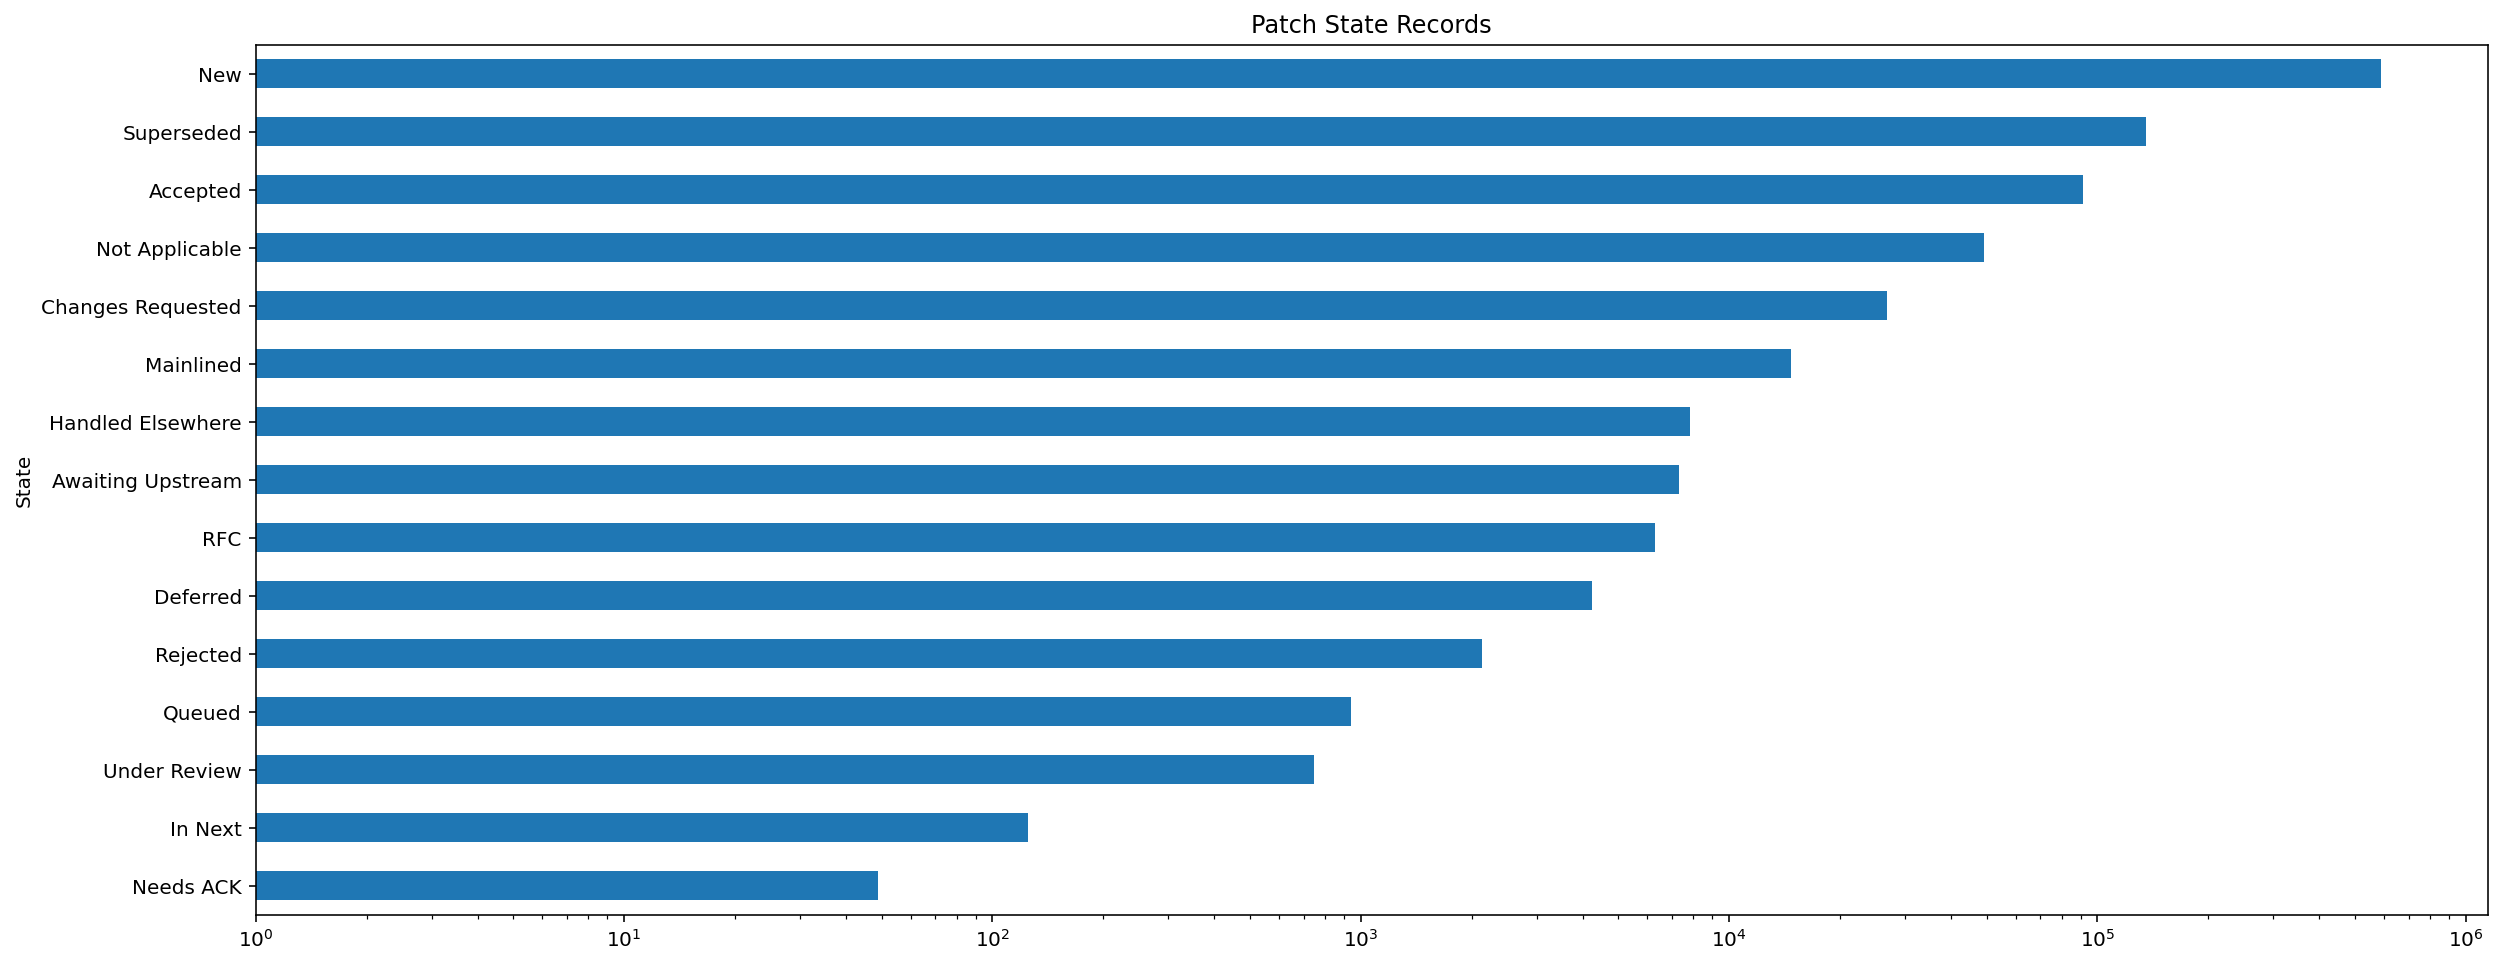

In [59]:
tmp_state.plot.barh(title="Patch State Records", xlabel="State", ylabel="Number of records", log=True, figsize=(20,8))

## &#129504; Generate Interest Data

Features of interest:

```python
['fkre_score',
 'fkgl_score',
 'message_exper',
 'commit_exper',
 'word_cnt',
 'sentence_cnt',
 'exert_influence',
 'patch_email',
 'first_patch_thread',
 'sent_time',
 'received_time',
 'reply_within_4hr',
 'patch_churn',
 'bug_fix',
 'new_feature',
 'accepted_patch',
 'accepted_commit']
 ```

### &#9759; Exert Influence Feature

In [60]:
# Based on the persuasion strategies in 
# Wang, X., Shi, W., Kim, R., Oh, Y., Yang, S., Zhang, J., & Yu, Z. (2019). 
# Persuasion for good: Towards a personalized persuasive dialogue system for social good.
# arXiv preprint [arXiv:1906.06725](https://arxiv.org/abs/1906.06725) 
persuasion_label = dict({
    0: 'task-related-inquiry', 
    1: 'credibility-appeal', 
    2: 'logical-appeal', 
    3: 'personal-related-inquiry', 
    4: 'source-related-inquiry', 
    5: 'donation-information', 
    6: 'foot-in-the-door', 
    7: 'emotion-appeal', 
    8: 'self-modeling', 
    9: 'personal-story',
    10: 'Unknown'})

In [61]:
# all persuasion strategies - the unknown one
persuasion_set = persuasion_label.keys() - {10}
persuasion_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [62]:
# exert influence through persuasion
df_email['exert_influence'] = df_email['persuasion'].apply(lambda x: 1 if (x in persuasion_set) else 0)

In [63]:
tmp_influence = df_email.groupby(df_email['exert_influence']).size().sort_values()
tmp_influence

exert_influence
0    370
dtype: int64

<AxesSubplot:title={'center':'Influence Records'}, ylabel='Influence'>

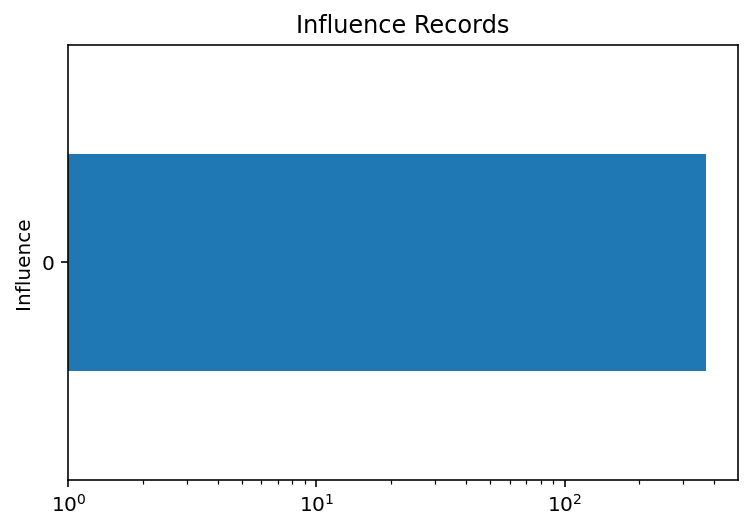

In [64]:
tmp_influence.plot.barh(title="Influence Records", xlabel="Influence", ylabel="Number of records", log=True)

### &#9759; NLP Features

* fkre_score
* fkgl_score
* word_cnt
* sentence_cnt

In [72]:
df_email['txt_to_spacy'] = df_email.apply(lambda row: text_to_spacy_nlp(email_body=row.clean_body), axis=1)

In [73]:
df_email['syllables_cnt'] = df_email.apply(lambda row: sum([count_syllables(s) for s in retrieve_words(spacy_txt=row.txt_to_spacy)]), axis=1)

### &#9759; Sentence Count Feature

In [74]:
df_email['sentence_cnt'] = df_email.apply(lambda row: sentence_count(spacy_txt=row.txt_to_spacy), axis=1)

### &#9759; Word Count Feature

In [75]:
df_email['word_cnt'] = df_email.apply(lambda row: word_count(spacy_txt=row.txt_to_spacy), axis=1)

### &#9759; FKRE Score Feature

In [76]:
df_email['fkre_score'] = df_email.apply(lambda row: fkre_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

### &#9759; FKGL Score Feature

In [77]:
df_email['fkgl_score'] = df_email.apply(lambda row: fkgl_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

In [78]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,...,persuasion,reply_to_message_id,sent_time,exert_influence,txt_to_spacy,syllables_cnt,sentence_cnt,word_cnt,fkre_score,fkgl_score
0,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,2020-08-01 09:49:51,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,...,Unknown,20200801084721.1812607-1-songliubraving@fb.com,2020-08-01 08:49:51,0,"(This, test, checks, the, correctness, of, BPF...",54,2,41,74.60,7.95
1,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,2020-08-01 16:02:31,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,...,Unknown,20200801150050.767038-1-masahiroy@kernel.org,2020-08-01 15:02:31,0,"(Commit, d26e94149276, (, "", kbuild, :, no, gc...",74,3,55,74.40,7.44
2,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,2020-08-01 14:06:29,[PATCH v11 2/5] x86: kdump: move reserve_crash...,...,Unknown,20200801130856.86625-1-chenzhou10@huawei.com,2020-08-01 13:06:29,0,"(In, preparation, for, supporting, reserve_cra...",73,4,57,84.02,5.08
3,33521,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008011049310,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,None,858,1596293371,2020-08-01 15:49:31,[PATCH] mm/swap.c: optimizing __pagevec_lru_ad...,...,Unknown,,2020-08-01 14:49:31,0,"(The, current, relock, logical, will, change, ...",108,4,91,83.34,7.29
4,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,2020-08-01 18:02:29,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,2020-08-01 17:02:29,0,"(On, 8/1/20, 4:36, AM, ,, Pavel, Begunkov, wro...",57,4,55,105.20,2.00


### &#9759; Patch Email Feature

In [79]:
def check_if_patch(w):
    """https://stackoverflow.com/questions/5319922/python-check-if-word-is-in-a-string"""
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [80]:
df_email['patch_email'] = df_email.apply(lambda row: 1 if check_if_patch("patch")(row['subject']) else 0, axis=1)

In [81]:
tmp_patch_email = df_email.groupby(df_email['patch_email']).size().sort_values()
tmp_patch_email

patch_email
0     43
1    327
dtype: int64

### &#9759; Patch Churn Feature

In [82]:
df_email['patch_churn'] = df_email.apply(lambda row: 1 if check_if_patch("patch")(row['subject']) else 0, axis=1)

### &#9759; Bug Fix Feature

In [83]:
# is_bug_fix = is_patch_churn
# is_new_feature = is_patch_churn
df_email['bug_fix'] = df_email.apply(lambda row: 1 if row['patch_churn'] == 1 else 0, axis=1)

### &#9759; New Feature

In [84]:
df_email['new_feature'] = df_email.apply(lambda row: 1 if row['patch_churn'] == 1 else 0, axis=1)

### &#9759; First Patch Thread Feature

In [ ]:
# thread_id: 20200801150050.767038-1-masahiroy@kernel.org

# ORIGINAL LOGIC: CHECK WITH HUASCAR
# is_first_patch_thread = 1 if not np.isnan(row['thread']) else 0

In [85]:
df_email['first_patch_thread'] = df_email.apply(lambda row: 1 if row['thread_id'] and not row['reply_to_message_id'] else 0, axis=1)

In [86]:
tmp_first_patch_thread = df_email.groupby(df_email['first_patch_thread']).size().sort_values()
tmp_first_patch_thread

first_patch_thread
1     78
0    292
dtype: int64

### &#9759; Accepted Patch Feature

* Patch is accepted if $state == Accepted$
* Patch is integrated, also known as is_commit_accepted, if $state == Mainlined$

In [87]:
def check_patch_state(patches_df: pd.DataFrame, search_column: str, search_value: str, state_value: str='Accepted') -> int:
    """Searches the Patch data based on search column value and state value

    Args:
      patches_df: input patches dataframe
      search_column: column to search at in patches dataframe
      search_value: target value in search column
      state_value: target state value, default: Accepted
    
    Returns:
      1 (True) if record exists, 0 (False) otherwise
    """

    res = patches_df[patches_df[search_column] == search_value]

    if not res.empty:
        # consider only the first result
        if res.iloc[0].state.casefold() == state_value.casefold():
            return 1
        else:
            return 0
    return 0

In [88]:
df_email['accepted_patch'] = df_email.apply(lambda row: check_patch_state(
    patches_df=df_patches, 
    search_column='mail_id', 
    search_value=row['message_id'], 
    state_value='Accepted'), axis=1)

In [89]:
tmp_accepted_patch = df_email.groupby(df_email['accepted_patch']).size().sort_values()
tmp_accepted_patch

accepted_patch
1      5
0    365
dtype: int64

### &#9759; Accepted Commit Feature

In [90]:
df_email['accepted_commit'] = df_email.apply(lambda row: check_patch_state(
    patches_df=df_patches, 
    search_column='mail_id', 
    search_value=row['message_id'], 
    state_value='Mainlined'), axis=1)

In [91]:
tmp_accepted_commit = df_email.groupby(df_email['accepted_commit']).size().sort_values()
tmp_accepted_commit

accepted_commit
1      2
0    368
dtype: int64

### &#9759; reply_within_4hr Feature

In [98]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   370 non-null    int64         
 1   url                  370 non-null    object        
 2   mailing_list_id      370 non-null    int64         
 3   email_id             370 non-null    object        
 4   message_id           370 non-null    object        
 5   reply_to_url         193 non-null    object        
 6   author_id            370 non-null    int64         
 7   timestamp_sent       370 non-null    int64         
 8   timestamp_recv       370 non-null    datetime64[ns]
 9   subject              370 non-null    object        
 10  body                 370 non-null    object        
 11  clean_body           370 non-null    object        
 12  thread_id            370 non-null    object        
 13  persuasion           370 non-null  

In [99]:
def time_lapsed_in_seconds(email_df, target_email):
    """Given an email search for the earliest email in the dataframe 
       that replies to it and calculate time lapsed in seconds.
       
       TLDR: 
       1. Search for the emails where in_reply_to == email_id
       2. Sort the answer if the returned DF is not empty
       3. Get the earliest response
       4. Do the time difference
       
       return time_lapsed_in_min if reply exists
       return -1 if the email has not received any reply
    """
    tmp_df = email_df[email_df['reply_to_message_id'] == target_email['message_id']]
    
    if not tmp_df.empty:
        tmp_df_sorted = tmp_df.sort_values(by='sent_time', ascending=True)
        time_diff = tmp_df_sorted.iloc[0]['sent_time'] - target_email['sent_time']
        time_lapsed_secs = time_diff.total_seconds()
        return abs(time_lapsed_secs)
    else:
        return -1

In [100]:
df_email['time_lapsed'] = df_email.apply(lambda row: time_lapsed_in_seconds(email_df=df_email, target_email=row), axis=1)

In [101]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,...,patch_email,patch_churn,bug_fix,new_feature,first_patch_thread,accepted_patch,accepted_commit,commit_experience,message_experience,time_lapsed
0,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,2020-08-01 09:49:51,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,...,1,1,1,1,0,0,0,0,0,-1.0
1,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,2020-08-01 16:02:31,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,...,1,1,1,1,0,0,0,0,0,-1.0
2,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,2020-08-01 14:06:29,[PATCH v11 2/5] x86: kdump: move reserve_crash...,...,1,1,1,1,0,0,0,0,0,-1.0
3,33521,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008011049310,d43150db4486c8e4f23336d0266fefc1@NO-ID-FOUND.m...,None,858,1596293371,2020-08-01 15:49:31,[PATCH] mm/swap.c: optimizing __pagevec_lru_ad...,...,1,1,1,1,1,0,0,0,0,-1.0
4,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,2020-08-01 18:02:29,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),...,1,1,1,1,0,0,0,0,0,-1.0


In [102]:
# is_quickly_replied
# Prior analysis on the LKML confirmed that patch emails
# tend to get a response within 3.5 hrs (on average).
# For sake of simplicity, we used 4 hrs instead of 3.5 hrs. 
# 4 * 60 * 60
four_h_lapse = 14400
df_email['is_quickly_replied'] = df_email['time_lapsed'].apply(lambda x: 1 if (x <= four_h_lapse and x != -1) else 0)

### &#9759; Message Experience Feature

In [ ]:
# def retrieve_message_experience(developer_data_list, sender_id, timestamp_sent):
#     cnt = 0
#     if len(developer_data_list) > 0:
#         for record in developer_data_list:
#             # each record is a dictionary
#             if record['sender_id'] == sender_id and record['sent_time'] <= timestamp_sent and record['is_patch_email'] == 1:
#                 cnt += 1
#     return cnt

In [96]:
def message_experience(email_df: pd.DataFrame, author_id: int, sent_time: np.datetime64) -> int:
    """Count the number of patch emails sent by a developer in earlier threads

    Args:
      email_df: input email dataframe
      author_id: target author ID
      sent_time: sent time of the current record into consideration
    
    Returns:
      The number of prior records in the email data that were patch emails
    """

    result_df = email_df.loc[(email_df.author_id == author_id) & (email_df.sent_time <= sent_time) & (email_df.accepted_patch == 1)]

    records_number = len(result_df)
    
    return records_number

In [97]:
df_email['message_experience'] = df_email.apply(lambda row: message_experience(email_df=df_email, author_id=row.author_id, sent_time=row.sent_time), axis=1)

### &#9759; Commit Experience Feature

In [ ]:
# def retrieve_commit_experience(developer_data_list, sender_id, timestamp_sent):
#     cnt = 0
#     if len(developer_data_list) > 0:
#         for record in developer_data_list:
#             # parsing each record in the dictionary so far
#             if record['sender_id'] == sender_id and record['sent_time'] <= timestamp_sent and record['is_accepted_commit'] == 1:
#                 cnt += 1
#     return cnt

In [93]:
def commit_experience(email_df: pd.DataFrame, author_id: int, sent_time: np.datetime64) -> int:
    """Count the previous records of a user which resulted in an accepted commit

    Args:
      email_df: input email dataframe
      author_id: target author ID
      sent_time: sent time of the current record into consideration
    
    Returns:
      The number of prior records in the email data that resulted in an accepted commit.
    """

    result_df = email_df.loc[(email_df.author_id == author_id) & (email_df.sent_time <= sent_time) & (email_df.accepted_commit == 1)]

    records_number = len(result_df)
    
    return records_number

In [94]:
df_email['commit_experience'] = df_email.apply(lambda row: commit_experience(email_df=df_email, author_id=row.author_id, sent_time=row.sent_time), axis=1)

In [95]:
df_email.commit_experience.max(), df_email.commit_experience.min()

(1, 0)

## &#9759; Interest DF

In [104]:
COLUMNS_OF_INTEREST = ['fkre_score', 'fkgl_score', 'message_experience', 'commit_experience', 
                       'word_cnt', 'sentence_cnt', 'exert_influence', 'patch_email', 
                       'first_patch_thread', 'sent_time', 'timestamp_recv', 'is_quickly_replied', 
                       'patch_churn', 'bug_fix', 'new_feature', 'accepted_patch', 'accepted_commit']

In [105]:
interest_df = df_email[COLUMNS_OF_INTEREST].copy()

# Compute catch email verbosity (ratio of word count to sentence count)
interest_df['verbosity'] = interest_df['word_cnt'] / interest_df['sentence_cnt']
## Replace NaN cases with Zero and the drop word and sentence counts
interest_df.fillna(value={'verbosity': 0}, inplace=True)
interest_df.drop(['word_cnt', 'sentence_cnt'], axis = 1, inplace=True)
interest_df.head()

,fkre_score,fkgl_score,message_experience,commit_experience,exert_influence,patch_email,first_patch_thread,sent_time,timestamp_recv,is_quickly_replied,patch_churn,bug_fix,new_feature,accepted_patch,accepted_commit,verbosity
0,74.60,7.95,0,0,0,1,0,2020-08-01 08:49:51,2020-08-01 09:49:51,0,1,1,1,0,0,20.500000
1,74.40,7.44,0,0,0,1,0,2020-08-01 15:02:31,2020-08-01 16:02:31,0,1,1,1,0,0,18.333333
2,84.02,5.08,0,0,0,1,0,2020-08-01 13:06:29,2020-08-01 14:06:29,0,1,1,1,0,0,14.250000
3,83.34,7.29,0,0,0,1,1,2020-08-01 14:49:31,2020-08-01 15:49:31,0,1,1,1,0,0,22.750000
4,105.20,2.00,0,0,0,1,0,2020-08-01 17:02:29,2020-08-01 18:02:29,0,1,1,1,0,0,13.750000
